In [10]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as py

In [31]:
#Read the datafile into a DataFrame
#The supplied files are clean, if you have data with nans or null values, you may have to do some extra cleaning up

df = pd.read_csv('c:/temp/bigcycledata.csv',dtype={'Watts':np.int,'Cadence':np.int,'HeartRate':np.int},parse_dates=True)
#df = pd.read_csv('c:/temp/cycledata.csv',parse_dates=True)

start = dt.now()
print('Start at ',start)

#Change the string datetime to a proper datetime format

df['datetime']=pd.to_datetime(df.Time)

# Set the elapsed duration between between each subsequent row 
# this would normally be 1 second, but sometimes it isn't

df['duration']=(df.datetime.shift(periods=-1)-df.datetime)

# Update NaT values to 0 seconds, as our dataframe is not allowed to contain non numeric values

df.loc[df['duration'].isnull(),'duration']=np.timedelta64(1,'s')

# Steps to create a powercurve like you will find in strava

# Turn the duration into an integer value in seconds
df['durationseconds']=np.divide(df['duration'], np.timedelta64(1, 's'))

# This value will be used to create a sensible log scale on the powercurve graph
logscale = 0.4

# Create a dataframe that lists all the instances of all the watts in the data
# plus the total time in each instance
spc=pd.DataFrame(df.groupby(['Watts']).durationseconds.sum())

# Sort by highest watts first
spc.reset_index(inplace=True)
spc.sort_values(by=['Watts'],ascending = False,inplace=True)

# Calculate work (watts x duration) + cumulative work  + cumulative average power
spc['work']=spc.Watts*spc.durationseconds
spc['cumwork']=spc.work.cumsum()
spc['cumduration']=spc.durationseconds.cumsum()
spc['averagecumpower']=spc.cumwork/spc.cumduration

# Calculate the log value to be used during graphing
spc['logcumdur']=spc.cumduration**logscale

spc.reset_index(inplace=True)

end = dt.now()

dur = round(df.durationseconds.sum()/3600.0,3)

print('  End at ',end,'\n  time taken for a ride of ',dur,' hours = ',end-start)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#   display(spc)

Start at  2020-03-04 21:43:26.894361
  End at  2020-03-04 21:43:26.921288 
  time taken for a ride of  5.951  hours =  0:00:00.026927


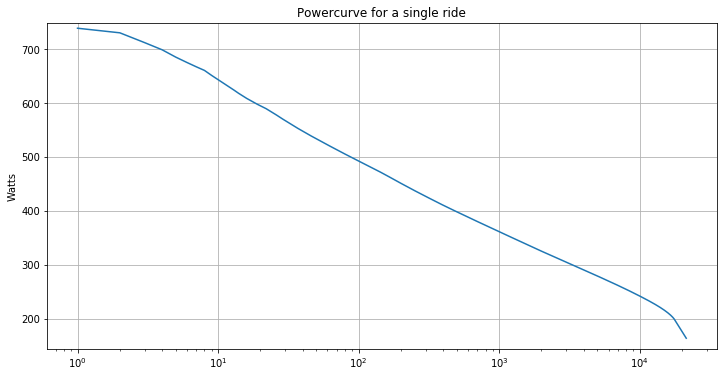

In [35]:
## Unfortunately the next bit is a bit faffy - this is to enable showing sensible labels on the pyplot graph

# Set the xticks at 1s, 15s, 1m, 2m, etc
xticks=[1,15,60,300,600,1200,1800,2700,3600,5400,3600*2,3600*3,3600*4,3600*5,3600*6,3600*8,3600*12,3600*18]

xlabels=[]
xvalues=[]

# We need to be able to choose the value in spc that comes closest to the desired tick mark
spc['nextlogcumdur']=spc.logcumdur.shift(periods=-1)

# Now we can populate the two arrays that will contain the position of the actual tick marks, and their respective labels
for i in range(0,len(xticks)):
    logvalue = xticks[i]**logscale
    try:
        #if we want the labels to be anally accurate, use this:
        labelvalue = spc.loc[(spc.logcumdur<=logvalue) & (spc.nextlogcumdur>logvalue),'cumduration'].iloc[0]
        #if we want the labels to be 'neat' we can use xticks[i] as the labelvalue
        labelvalue = xticks[i]
        
        hourvalue = int(labelvalue/3600)
        minutevalue = int((labelvalue-hourvalue*3600)/60)
        secondvalue = int(labelvalue-hourvalue*3600-minutevalue*60)
        if labelvalue < 60:
            labeltext = str(secondvalue)+'s'
        elif labelvalue < 3600:
            labeltext = str(minutevalue) + 'm ' 
            if secondvalue != 0:
                labeltext += str(secondvalue) + 's'
        else:
            labeltext = str(hourvalue) + 'h ' 
            if minutevalue != 0:
                labeltext += str(minutevalue) + 'm'
        xvalues.append(logvalue)
        xlabels.append(labeltext)
    except IndexError:
        #Means we have reached the max duration of the ride
        continue
        
#display (xlabels,xvalues)

# And now we can draw the actual graph
py.close()

fig = py.figure(figsize = (12,6))
ax = fig.add_subplot(111)
py.title('Powercurve for a single ride')
py.ylabel('Watts')
ax.grid()
py.ylim(spc.averagecumpower.min()-20,spc.averagecumpower.max()+10)
py.xscale('log')
py.plot(spc.cumduration,spc.averagecumpower)
#py.xticks(xvalues, xlabels, rotation='vertical')


py.show()
